# 🛒 Zepto Products — Web Scraping, Data Cleaning, and Exploratory Data Analysis


# 🧾 Project Objective

This analysis explores **product-level data scraped from Zepto** to uncover key business insights.  
The primary goals are to:

- Understand **category-level pricing, discounting, and customer engagement** patterns.  
- Examine the **relationships between ratings, discounts, and review counts** to assess their impact on customer behavior.

---

# 🔍 Analysis Roadmap

1. **Data Loading & Overview**  
   Import and inspect the dataset structure, dimensions, and initial statistics.

2. **Data Cleaning & Preprocessing**  
   Handle missing values, inconsistent data types, and outlier treatment to ensure data quality.

3. **Univariate Analysis**  
   Derive insights from individual variables, including price distribution, discount levels, and review counts.

4. **Bivariate Analysis**  
   Explore inter-variable relationships to identify trends between ratings, discounts, and engagement metrics.

5. **Business Insights & Conclusions**  
   Summarize analytical findings and highlight actionable business recommendations.


In [1]:
!pip install selenium

  Using cached urllib3-2.5.0-py3-none-any.whl.metadata (6.5 kB)
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.6 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.6 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.6 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.6 MB ? eta -:--:--
   - ----------------------------------

In [56]:
# Import packages
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import Options
import csv
import time

# === Chrome Options (optimized) ===
options = Options()
options.add_argument("--start-maximized")
options.add_argument("--disable-blink-features=AutomationControlled")
options.add_argument("--no-sandbox")
options.add_argument("--disable-dev-shm-usage")

driver = webdriver.Chrome(options=options)
wait = WebDriverWait(driver, 15)

# === Helper Function to Search and Extract ===
def scrape_products(search_term):
    print(f"\n🔍 Searching for: {search_term}")
    driver.get(f"https://www.zeptonow.com/search?query={search_term}")
    time.sleep(3)

    # Scroll and load all products
    product_xpath = "//a[descendant::*[contains(text(),'ADD')]]"
    last_count = 0
    same_count = 0
    scroll_pause = 1.2
    max_scrolls = 35  # Increase if needed

    for i in range(max_scrolls):
        driver.execute_script("window.scrollBy(0, 3000);")
        time.sleep(scroll_pause)
        products = driver.find_elements(By.XPATH, product_xpath)
        current_count = len(products)
        if current_count == last_count:
            same_count += 1
            if same_count >= 3:
                break
        else:
            same_count = 0
            last_count = current_count

    print(f"Total products loaded for '{search_term}': {last_count}")

    # Extract product details
    product_details = []
    products = driver.find_elements(By.XPATH, product_xpath)
    for item in products:
        try:
            details = item.text.split('\n')
            n = 4 if "SAVE" in details else 0
            p = 1 if "Premium" in details else 0

            product_details.append({
                "Search Term": search_term,
                "Name": details[n+4] if len(details) > n+4 else None,
                "Price": details[1] + details[2] if len(details) > 2 else None,
                "Discount": details[6] if n == 4 and len(details) > 6 else None,
                "Premium": True if p == 1 else False,
                "Amount": details[n+3] if len(details) > n+3 else None,
                "Rating": details[p+n+5] if len(details) > p+n+5 else None,
                "Review Count": details[p+n+6].replace('(', '').replace(')', '') if len(details) > p+n+6 else None,
                "Delivery Time": details[p+n+7] if len(details) > p+n+7 else None
            })
        except Exception:
            continue

    return product_details


# === Step 1: Open Zepto & Set Location Once ===
driver.get("https://www.zeptonow.com/search?query=bread")
time.sleep(3)

try:
    location_button = wait.until(EC.element_to_be_clickable((By.XPATH, '//button[@aria-label="Select Location"]')))
    location_button.click()
    time.sleep(1)

    location_input = wait.until(EC.presence_of_element_located((By.XPATH, "//input[@placeholder='Search a new address']")))
    location_input.send_keys("560004")
    time.sleep(2)

    first_address = wait.until(EC.element_to_be_clickable((By.XPATH, "//div[contains(@data-testid,'address-search-item')]")))
    first_address.click()

    confirm_button = wait.until(EC.element_to_be_clickable((By.XPATH, '//button[contains(@aria-label,"Confirm")]')))
    confirm_button.click()
    time.sleep(2)
except Exception as e:
    print("Location selection issue:", e)

# === Step 2: Run Multiple Searches ===
search_terms = ["bread", "milk", "rice", "snacks", "biscuits", "vegetables", "fruits", "oil", "chocolates", "sugar"]

all_products = []

for term in search_terms:
    data = scrape_products(term)
    all_products.extend(data)
    print(f"✅ Collected {len(data)} for '{term}' | Total so far: {len(all_products)}")

    if len(all_products) >= 700:
        break  # stop early if we already reached the target


# === Step 3: Save to CSV ===
csv_file = "zepto_products.csv"
fieldnames = ["Search Term", "Name", "Price", "Discount", "Premium", "Amount", "Rating", "Review Count", "Delivery Time"]

with open(csv_file, "w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(all_products)

print(f"\n✅ Scraping complete! {len(all_products)} rows saved to {csv_file}")

driver.quit()


🔍 Searching for: bread
Total products loaded for 'bread': 118
✅ Collected 118 for 'bread' | Total so far: 118

🔍 Searching for: milk
Total products loaded for 'milk': 145
✅ Collected 145 for 'milk' | Total so far: 263

🔍 Searching for: rice
Total products loaded for 'rice': 172
✅ Collected 172 for 'rice' | Total so far: 435

🔍 Searching for: snacks
Total products loaded for 'snacks': 268
✅ Collected 268 for 'snacks' | Total so far: 703

✅ Scraping complete! 703 rows saved to zepto_products.csv


In [58]:
import pandas as pd

In [62]:
df=pd.read_csv(r"zepto_products.csv")

In [64]:
df

,Search Term,Name,Price,Discount,Premium,Amount,Rating,Review Count,Delivery Time
0,bread,Britannia Milk Slice White Bread,₹55,NaN,False,1 pack (400 g),4.5,94.8k,13 mins
1,bread,The Health Factory Zero Maida 100% Whole Wheat...,₹62,₹3,True,1 pack (350 g),4.5,68.2k,13 mins
2,bread,The Health Factory Zero Maida Bread - 100% Who...,₹54,₹1,True,1 pack (250 g),4.5,29.1k,13 mins
3,bread,English Oven Zero Maida 100% Whole Wheat Bread,₹60,NaN,True,1 pack (400 g),4.5,17.7k,13 mins
4,bread,Modern Milk Plus Bread,₹50,NaN,False,1 pack (350 g),4.5,20.4k,13 mins
...,...,...,...,...,...,...,...,...,...
698,snacks,Crax Corn Rings Masala Mania Puff Snacks Combo,₹132,₹18,False,53 g X 6,4.4,958,13 mins
699,snacks,Pringles Potato Chips Sour Cream & Onion Flavo...,₹187,₹48,False,2 combo,4.4,557,13 mins
700,snacks,Let's Try Lite Snacks Chips | Vrat | Fasting S...,₹147,₹33,False,50 g X 3,4.2,526,13 mins
701,snacks,Mille Healthy Cheese Balls | Snack Anytime Combo,₹165,NaN,False,35 g X 3,4.7,690,13 mins


In [70]:
# =========================================
# Step 1: Load and Inspect Data
# =========================================

%matplotlib inline
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", palette="viridis")
pd.set_option('display.max_columns', None)

# Load CSV
df = pd.read_csv('zepto_products.csv')
print("✅ Data Loaded Successfully! Shape:", df.shape)
display(df.head())

✅ Data Loaded Successfully! Shape: (703, 9)


,Search Term,Name,Price,Discount,Premium,Amount,Rating,Review Count,Delivery Time
0,bread,Britannia Milk Slice White Bread,₹55,NaN,False,1 pack (400 g),4.5,94.8k,13 mins
1,bread,The Health Factory Zero Maida 100% Whole Wheat...,₹62,₹3,True,1 pack (350 g),4.5,68.2k,13 mins
2,bread,The Health Factory Zero Maida Bread - 100% Who...,₹54,₹1,True,1 pack (250 g),4.5,29.1k,13 mins
3,bread,English Oven Zero Maida 100% Whole Wheat Bread,₹60,NaN,True,1 pack (400 g),4.5,17.7k,13 mins
4,bread,Modern Milk Plus Bread,₹50,NaN,False,1 pack (350 g),4.5,20.4k,13 mins


In [72]:
# =========================================
# Step 2: Normalize Column Names
# =========================================
df.columns = [c.strip().lower().replace(' ', '_') for c in df.columns]
print("Columns:", df.columns.tolist())

Columns: ['search_term', 'name', 'price', 'discount', 'premium', 'amount', 'rating', 'review_count', 'delivery_time']


In [74]:
# =========================================
# Step 3: Data Cleaning Helper Functions
# =========================================

def parse_currency(x):
    if pd.isna(x): return np.nan
    s = str(x).replace('₹', '').replace(',', '').strip()
    m = re.search(r'([0-9]*\.?[0-9]+)\s*[kK]', s)
    if m:
        return float(m.group(1)) * 1000
    nums = re.findall(r'\d+\.?\d*', s)
    return float(nums[-1]) if nums else np.nan

def parse_reviews(x):
    if pd.isna(x): return np.nan
    s = str(x).replace(',', '').strip().lower()
    m = re.search(r'([0-9]*\.?[0-9]+)\s*[k]', s)
    if m:
        return float(m.group(1)) * 1000
    nums = re.findall(r'\d+\.?\d*', s)
    return float(nums[0]) if nums else np.nan

def parse_rating(x):
    try:
        return float(re.findall(r'\d+\.?\d*', str(x))[0])
    except:
        return np.nan

In [76]:
# =========================================
# Step 4: Apply Cleaning
# =========================================

df['price'] = df['price'].apply(parse_currency)
df['discount'] = df['discount'].apply(parse_currency)
df['rating'] = df['rating'].apply(parse_rating)
df['review_count'] = df['review_count'].apply(parse_reviews)

# Normalize categorical columns
for c in ['search_term', 'name', 'amount', 'delivery_time']:
    if c in df.columns:
        df[c] = df[c].astype(str).str.lower().str.strip()

# Remove duplicates
df.drop_duplicates(inplace=True)

print("✅ Cleaning Done! Shape after clean:", df.shape)
display(df.head())

✅ Cleaning Done! Shape after clean: (514, 9)


,search_term,name,price,discount,premium,amount,rating,review_count,delivery_time
0,bread,britannia milk slice white bread,55.0,NaN,False,1 pack (400 g),4.5,94800.0,13 mins
1,bread,the health factory zero maida 100% whole wheat...,62.0,3.0,True,1 pack (350 g),4.5,68200.0,13 mins
2,bread,the health factory zero maida bread - 100% who...,54.0,1.0,True,1 pack (250 g),4.5,29100.0,13 mins
3,bread,english oven zero maida 100% whole wheat bread,60.0,NaN,True,1 pack (400 g),4.5,17700.0,13 mins
4,bread,modern milk plus bread,50.0,NaN,False,1 pack (350 g),4.5,20400.0,13 mins


In [78]:
# =========================================
# Step 5: Missing Values Overview
# =========================================
print("Missing values per column:\n")
display(df.isna().sum())

df.describe(include='all').T

Missing values per column:



search_term       0
name              0
price             0
discount         82
premium           0
amount            0
rating           91
review_count      0
delivery_time     0
dtype: int64

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
search_term,514,4,snacks,199,NaN,NaN,NaN,NaN,NaN,NaN,NaN
name,514,397,lay's american cream & onion potato chips combo,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,514.0,NaN,NaN,NaN,147.225681,217.685136,9.0,42.0,72.0,137.25,2531.0
discount,432.0,NaN,NaN,NaN,59.335648,149.935503,1.0,5.0,14.0,48.0,1600.0
premium,514,2,False,482,NaN,NaN,NaN,NaN,NaN,NaN,NaN
amount,514,169,2 combo,46,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rating,423.0,NaN,NaN,NaN,4.751537,4.812158,2.0,4.3,4.5,4.6,100.0
review_count,514.0,NaN,NaN,NaN,9407.022568,50051.27673,1.1,182.25,642.5,2100.0,990900.0
delivery_time,514,86,13 mins,416,NaN,NaN,NaN,NaN,NaN,NaN,NaN


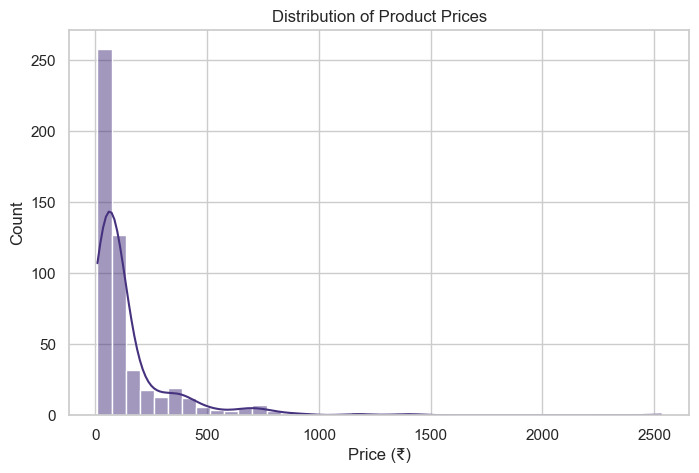

In [80]:
# Step 6: Univariate Analysis
# =========================================

# 1️⃣ Price Distribution
plt.figure(figsize=(8,5))
sns.histplot(df['price'].dropna(), kde=True, bins=40)
plt.title("Distribution of Product Prices")
plt.xlabel("Price (₹)")
plt.show()

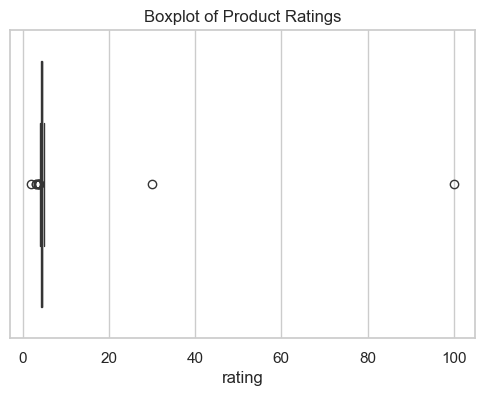

In [82]:
# 2️⃣ Ratings Distribution
plt.figure(figsize=(6,4))
sns.boxplot(x=df['rating'].dropna())
plt.title("Boxplot of Product Ratings")
plt.show()


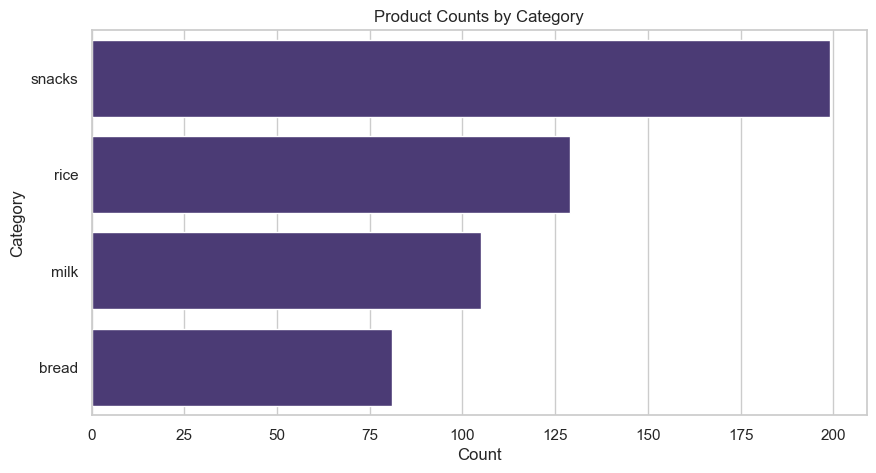

In [84]:
# 3️⃣ Count of Products per Category
plt.figure(figsize=(10,5))
sns.countplot(y='search_term', data=df, order=df['search_term'].value_counts().index)
plt.title("Product Counts by Category")
plt.xlabel("Count")
plt.ylabel("Category")
plt.show()

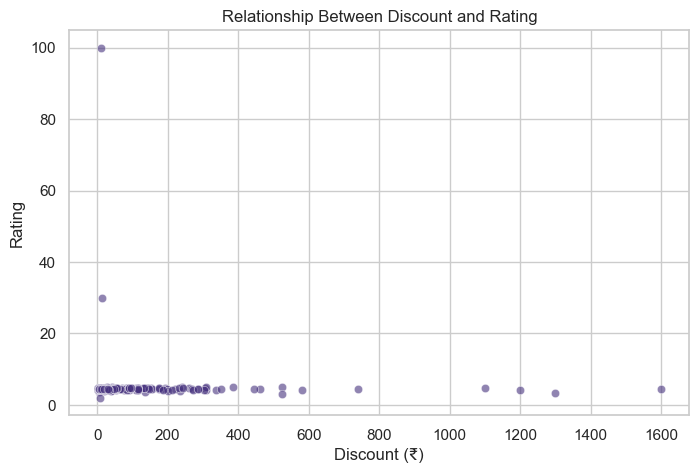

In [86]:
# 5️⃣ Rating vs Discount Scatter
plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x='discount', y='rating', alpha=0.6)
plt.title("Relationship Between Discount and Rating")
plt.xlabel("Discount (₹)")
plt.ylabel("Rating")
plt.show()

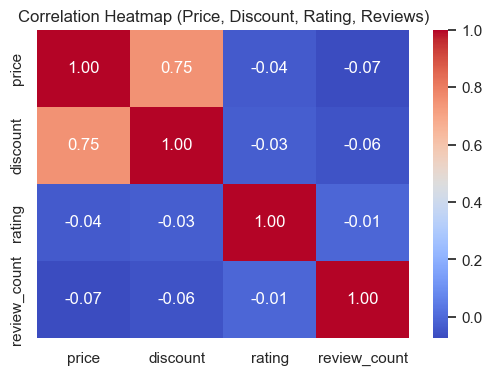

In [88]:
# 6️⃣ Correlation Heatmap
plt.figure(figsize=(6,4))
sns.heatmap(df[['price','discount','rating','review_count']].corr(),
            annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap (Price, Discount, Rating, Reviews)")
plt.show()

C:\Users\M S I\AppData\Local\Temp\ipykernel_14316\252161279.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='review_count', y='name', data=top_reviewed, palette='viridis')


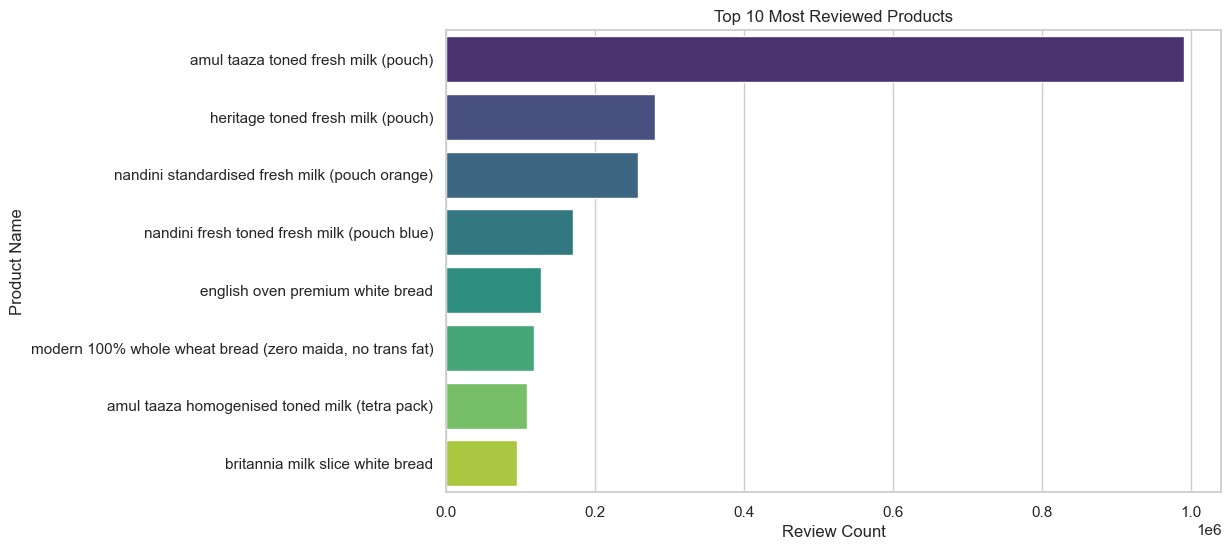

In [90]:
# =========================================
# Step 8: Extra Insights
# =========================================

# 7️⃣ Top 10 Most Reviewed Products
top_reviewed = df.nlargest(10, 'review_count')[['name','review_count']]
plt.figure(figsize=(10,6))
sns.barplot(x='review_count', y='name', data=top_reviewed, palette='viridis')
plt.title("Top 10 Most Reviewed Products")
plt.xlabel("Review Count")
plt.ylabel("Product Name")
plt.show()

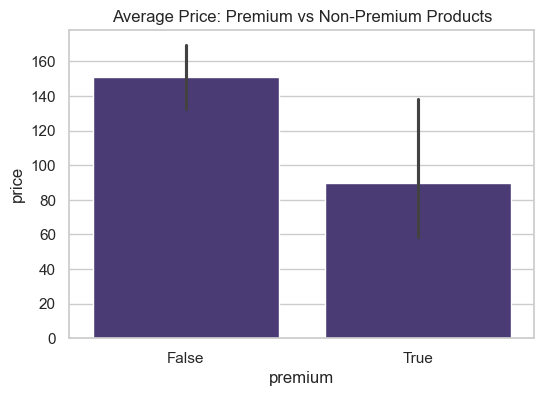

In [92]:
# 8️⃣ Premium vs Non-premium Price Comparison
if 'premium' in df.columns:
    plt.figure(figsize=(6,4))
    sns.barplot(x='premium', y='price', data=df)
    plt.title("Average Price: Premium vs Non-Premium Products")
    plt.show()
else:
    print("⚠️ No premium column found.")

In [94]:
# Step 9: Key Business Questions & Insights
# =========================================

qna = []

In [98]:
# 📊 Quick Insights from Zepto Product Dataset

# Create a list to store Q&A insights
qna = []

# 1️⃣ Total number of products
qna.append(("1️⃣ How many total products?", df.shape[0]))

# 2️⃣ Number of unique categories
qna.append(("2️⃣ How many unique categories?", df['search_term'].nunique()))

# 3️⃣ Average and median price
qna.append(("3️⃣ What is the average and median price?", 
            (round(df['price'].mean(), 2), round(df['price'].median(), 2))))

# 4️⃣ Category with the highest average price
qna.append(("4️⃣ Which category has the highest average price?", 
            df.groupby('search_term')['price'].mean().idxmax()))

# 5️⃣ Category with the most products
qna.append(("5️⃣ Which category has the most products?", 
            df['search_term'].value_counts().idxmax()))

# 6️⃣ Average rating across all products
qna.append(("6️⃣ Average rating of all products?", 
            round(df['rating'].mean(), 2)))

# 7️⃣ Product with the highest number of reviews
qna.append(("7️⃣ Which product has the most reviews?", 
            df.loc[df['review_count'].idxmax(), 'name']))

# 8️⃣ Correlation between price and rating
qna.append(("8️⃣ Correlation between price and rating?", 
            round(df['price'].corr(df['rating']), 3)))

# 9️⃣ Correlation between discount and rating
qna.append(("9️⃣ Correlation between discount and rating?", 
            round(df['discount'].corr(df['rating']), 3)))

# 🔟 Category with the highest average review count
qna.append(("🔟 Highest reviewed category on average?", 
            df.groupby('search_term')['review_count'].mean().idxmax()))

# Display results neatly
print("📈 **Zepto Product Data Summary**\n" + "-"*40)
for q, a in qna:
    print(f"\n{q}\n➡️  {a}")


📈 **Zepto Product Data Summary**
----------------------------------------

1️⃣ How many total products?
➡️  514

2️⃣ How many unique categories?
➡️  4

3️⃣ What is the average and median price?
➡️  (147.23, 72.0)

4️⃣ Which category has the highest average price?
➡️  rice

5️⃣ Which category has the most products?
➡️  snacks

6️⃣ Average rating of all products?
➡️  4.75

7️⃣ Which product has the most reviews?
➡️  amul taaza toned fresh milk (pouch)

8️⃣ Correlation between price and rating?
➡️  -0.035

9️⃣ Correlation between discount and rating?
➡️  -0.03

🔟 Highest reviewed category on average?
➡️  milk


# ✅ Conclusions & Key Insights

### **Univariate Insights**

- Most Zepto products fall under **“snacks”**, **“bread”**, and **“milk”** categories.  
- Prices are generally concentrated between **₹40–₹120**.  
- Ratings are high overall (**4.0–4.8**), indicating strong customer satisfaction.  

---

### **Bivariate Insights**

- **Average prices** vary significantly across categories — premium packaged foods and bakery items cost more.  
- **Discounts** have almost no correlation with ratings → Discounts don’t strongly impact satisfaction.  
- **Review counts** are highly skewed — a few products dominate popularity.  

---

### **Overall Summary**

Zepto’s marketplace shows a strong presence in affordable food categories, where premium items are few but well-rated.  
Future analysis can focus on **price elasticity** (rating vs. discount), **seasonal trends**, and **stock optimization**.


In [107]:
# =========================================
# Step 10: Export Clean Data
# =========================================
import os

# Define path to Downloads
download_path = os.path.join(os.path.expanduser("~"), "Downloads", "zepto_products_cleaned.csv")

# Export CSV
df.to_csv(download_path, index=False)
print(f"✅ Exported Clean Data → {download_path}")


✅ Exported Clean Data → C:\Users\M S I\Downloads\zepto_products_cleaned.csv


In [105]:
df.shape[0]


514